In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random 
import time
from scipy.stats import rankdata

In [2]:
def TDT(n):
    b = n[0] + n[2] + 2*n[3]
    c = n[1] + n[2] + 2*n[4]
    
    if b == 0 and c == 0:
        return 0
    elif b == 0:
        return 1000000000
    else:
        return (b-c)**2/(b+c)

In [3]:
def lap_normal(stats, s, epsilon, K, m):
    g = sorted(stats, reverse=True)
    pri_data = g + np.random.laplace(loc = 0.0, scale = (2*K*s)/epsilon, size=np.size(stats))
    pri_r = np.argsort(pri_data)
    
    return pri_r[m-K:m]

In [4]:
def random_num(pd):
    dist = np.cumsum(pd).tolist()
    dist[-1] = 1.0
    num = np.random.rand()
    dist.append(num)
    return sorted(dist).index(num)

def exp_stats(stats, s, epsilon, K, m):
    g = sorted(stats, reverse=True)
    
    h = np.zeros(m)
    for i in range(m):
        h[i] = g[i]
    S = np.zeros(K)
    k = 0
    
    w = np.zeros(m)
    p = np.zeros(m)
    
    while k < K:
        sumw = 0
        for i in range(m):
            w[i] = math.exp(epsilon * h[i] / (2*K*s))
            sumw += w[i]
        for i in range(m):
            p[i] = w[i]/sumw
            
        x = random_num(p)
        h[x] = -1000000.0
        S[k] = x
        k += 1
    
    return S

In [5]:
def SHD(cc, n):
    T = TDT(n)
    
    d = np.zeros(2)
    N = np.zeros(6)
    
    for k in range(6):
        N[k] = n[k]
    
    if T < cc:
        while T < cc:
            if N[4] > 0:
                N[4] -= 1
            elif N[1] > 0:
                N[1] -= 1
            elif N[2] > 0:
                N[2] -= 1
            elif N[5] > 0:
                N[5] -= 1
            else:
                N[0] -= 1
            N[3] += 1
            
            T = TDT(N)
            d[0] -= 1
        
        T = TDT(n)
        for k in range(6):
            N[k] = n[k]
        
        while T < cc:
            if N[3] > 0:
                N[3] -= 1
            elif N[0] > 0:
                N[0] -= 1
            elif N[2] > 0:
                N[2] -= 1
            elif N[5] > 0:
                N[5] -= 1
            else:
                N[1] -= 1
            N[4] += 1
            
            T = TDT(N)
            d[1] -= 1
        
        if d[0] > d[1]:
            return d[0]
        else:
            return d[1]
    
    else:
        step = 0
        
        if n[0] + 2*n[3] > n[1] + 2*n[4]:
            while T >= cc:
                if n[3] > 0:
                    n[3] -= 1
                elif n[0] > 0:
                    n[0] -= 1
                elif n[5] > 0:
                    n[5] -= 1
                elif n[2] > 0:
                    n[2] -= 1
                else:
                    n[1] -= 1
                n[4] += 1
            
                T = TDT(n)
                step += 1
        else:
            while T >= cc:
                if n[4] > 0:
                    n[4] -= 1
                elif n[1] > 0:
                    n[1] -= 1
                elif n[5] > 0:
                    n[5] -= 1
                elif n[2] > 0:
                    n[2] -= 1
                else:
                    n[0] -= 1
                n[3] += 1
            
                T = TDT(n)
                step += 1
        
        return step-1

def exp_shd(n, epsilon, K, m):
    shd = np.zeros(m)
    cc = 19.5
    
    for i in range(m):
        k = [int(n[i][0]), int(n[i][1]), int(n[i][2]), int(n[i][3]), int(n[i][4]), int(n[i][5])]
        shd[i] = SHD(cc,k)
    
    S = np.zeros(K)
    k = 0
    
    w = np.zeros(m)
    p = np.zeros(m)
    
    while k < K:
        sumw = 0
        for i in range(m):
            w[i] = math.exp(epsilon * shd[i] / (2*K))
            sumw += w[i]
        for i in range(m):
            p[i] = w[i]/sumw
            
        x = random_num(p)
        shd[x] = -1000000.0
        S[k] = x
        k += 1
    
    return S

In [6]:
def FPA(stats, sensitivity, epsilon, K, m):
    rank = np.argsort(stats)
    g = np.zeros(m)
    for i in range(m):
        g[i] = stats[i]
        
    zeros = np.zeros(m)
    y = np.fft.fft(g)
    prime_y = np.fft.fft(zeros)
    pri_x = np.zeros(m)
    
    s = int(m/(2*K))
    
    l = 2*K*sensitivity*np.sqrt(s)/epsilon
    
    prime_y[0:s] = y[0:s] + np.random.laplace(loc= 0.0, scale = l, size = s)
    
    pri_x = np.fft.ifft(prime_y).real
    
    pri_r = np.argsort(pri_x)
    
    for i in range(K):
        for j in range(m):
            if pri_r[m-i-1] == rank[m-j-1]:
                pri_r[m-i-1] = j
                break
    
    return pri_r[m-K:m]

In [7]:
def extended_FPA(stats, sensitivity, epsilon, K, m):
    g = sorted(stats, reverse=True)
    
    zeros = np.zeros(m)
    y = np.fft.fft(g)
    prime_y = np.fft.fft(zeros)
    
    s = int(m/(2*K))
    
    for i in range(s):
        if i == 0:
            prime_y[0] = y[0]
        else:
            prime_y[i] = y[i]
            prime_y.real[int(M)-i] = prime_y.real[i]
            prime_y.imag[int(M)-i] = -prime_y.imag[i]
    
    #prime_g = np.fft.ifft(prime_y)
    
    l = 2*K*sensitivity/epsilon
    
    pri_x = np.zeros(m)
    
    noise = np.zeros(m)
    
    for j in range(m):
        hat_y = np.fft.fft(zeros)
        p = np.random.laplace(loc= 0.0, scale = l, size = 1)
        hat_y.real[0] = prime_y.real[0] + p
        for k in range(1,s):
            hat_y.real[k] = prime_y.real[k] + p * math.cos(-2*j*k*math.pi/m)
            hat_y.imag[k] = prime_y.imag[k] + p * math.sin(-2*j*k*math.pi/m)
            hat_y.real[m-k] = hat_y.real[k]
            hat_y.imag[m-k] = -hat_y.imag[k]
            
        pri_x[j] = np.fft.ifft(hat_y).real[j]
        
    pri_r = np.argsort(pri_x)
    
    return pri_r[m-K:m]

In [8]:
def lap_DFT(stats, sensitivity, epsilon, K, m):
    g = sorted(stats, reverse=True)
    zeros = np.zeros(m)
    y = np.fft.fft(g)
    prime_y = np.fft.fft(zeros)
    
    s = int(m/(2*K))
    
    for i in range(s):
        if i == 0:
            prime_y[0] = y[0]
        else:
            prime_y[i] = y[i]
            prime_y.real[int(M)-i] = prime_y.real[i]
            prime_y.imag[int(M)-i] = -prime_y.imag[i]
    
    prime_g = np.fft.ifft(prime_y)
    
    pri_g = prime_g.real + np.random.laplace(loc = 0.0, scale = (2*K)*((2*s-1)/m)*sensitivity/epsilon, size=m)
    
    pri_r = np.argsort(pri_g)
    
    return pri_r[m-K:m]

In [9]:
def exp_DFT(stats, sensitivity, epsilon, K, m):
    g = sorted(stats, reverse=True)
    zeros = np.zeros(m)
    y = np.fft.fft(g)
    prime_y = np.fft.fft(zeros)
    
    s = int(m/(2*K))
    
    for i in range(s):
        if i == 0:
            prime_y[0] = y[0]
        else:
            prime_y[i] = y[i]
            prime_y.real[int(m)-i] = prime_y.real[i]
            prime_y.imag[int(m)-i] = -prime_y.imag[i]
    
    prime_g = np.fft.ifft(prime_y).real
    
    h = np.zeros(m)
    for i in range(m):
        h[i] = prime_g[i]
    S = np.zeros(K)
    k = 0
    
    w = np.zeros(m)
    p = np.zeros(m)
    
    while k < K:
        sumw = 0
        for i in range(m):
            w[i] = math.exp((epsilon * h[i] / (2*K*sensitivity)) * (m / (2*s-1)))
            sumw += w[i]
        for i in range(m):
            p[i] = w[i]/sumw
            
        x = random_num(p)
        h[x] = -1000000.0
        S[k] = x
        k += 1
    
    return S

In [10]:
#print(lap_normal(stats, 8, 3, 1, 5000))
#print(exp_stats(stats, 8, 3, 1, 5000))
#print(exp_shd(nn, 3, 5, 5000))
#print(extended_FPA(stats, 8, 3, 5, 5000))
#print(lap_DFT(stats, 8, 3, 5, 5000))
#print(exp_DFT(stats, 8, 3, 5, 5000))

In [11]:
def dataGenerator(N,M,nn):
    S = np.zeros(M)
    b = np.zeros(M)
    c = np.zeros(M)
    
    n = np.zeros((M,6))
    
    sig = random.sample(range(M),10)
    
    for i in range(10):
        S[sig[i]] = random.randint(0,2*N)
        b[sig[i]] = np.random.binomial(S[sig[i]],0.75)
        c[sig[i]] = S[sig[i]] - b[sig[i]]
        n[sig[i]][0] = b[sig[i]]
        n[sig[i]][1] = c[sig[i]]
        n[sig[i]][5] = 2*N - b[sig[i]] - c[sig[i]]
    
    for i in range(M):
        if S[i] == 0:
            S[i] = random.randint(0,2*N)
            b[i] = np.random.binomial(S[i],0.5)
            c[i] = S[i] - b[i]
            n[i][0] = b[i]
            n[i][1] = c[i]
            n[i][5] = 2*N - b[i] - c[i]
        
    stats = np.zeros(M)
    order = np.zeros(M)
    
    for i in range(M):
        order[i] = i
        if b[i] == 0 and c[i] == 0:
            stats[i] = 0
        else:
            stats[i] = (b[i]-c[i])**2/(b[i]+c[i])
    
    x = np.argsort(stats)
    #for i in range(10):
    #    print(x[M-1-i])
    
    #nn = np.zeros((M,6))
    for i in range(M):
        nn[i] = n[x[M-1-i]]
        
    return stats

def evaluation(K, N, M):
    accuracy = np.zeros((7,7))
    
    sensitivity = 8*(N-1)/N
    
    correct = np.zeros((7,7))
    
    epsilon = [0.1, 0.5, 1, 2, 3, 4, 5]
    
    for j in range(7):
        nn = np.zeros((M,6))
        stats = dataGenerator(N,M,nn)
        for i in range(7):
            lap_normal_result = lap_normal(stats, sensitivity, epsilon[i], K, M)
            exp_stats_result = exp_stats(stats, sensitivity, epsilon[i], K, M)
            exp_shd_result = exp_shd(nn, epsilon[i], K, M)
            FPA_result = FPA(stats, sensitivity, epsilon[i], K, M)
            extended_FPA_result = extended_FPA(stats, sensitivity, epsilon[i], K, M)
            lap_DFT_result = lap_DFT(stats, sensitivity, epsilon[i], K, M)
            exp_DFT_result = exp_DFT(stats, sensitivity, epsilon[i], K, M)
            for k in range(K):
                if lap_normal_result[k] < K:
                    correct[i][0] += 1
                if exp_stats_result[k] < K:
                    correct[i][1] += 1
                if exp_shd_result[k] < K:
                    correct[i][2] += 1
                if FPA_result[k] < K:
                    correct[i][3] += 1
                if extended_FPA_result[k] < K:
                    correct[i][4] += 1
                if lap_DFT_result[k] < K:
                    correct[i][5] += 1
                if exp_DFT_result[k] < K:
                    correct[i][6] += 1
            #print(correct)
        
    accuracy = correct/(K*7)    
    return accuracy

[[0.         0.         0.         0.         0.         0.01428571
  0.01428571]
 [0.01428571 0.         0.         0.         0.         0.01428571
  0.01428571]
 [0.         0.         0.         0.         0.         0.02857143
  0.02857143]
 [0.         0.         0.01428571 0.01428571 0.1        0.08571429
  0.15714286]
 [0.         0.01428571 0.14285714 0.04285714 0.47142857 0.32857143
  0.35714286]
 [0.         0.01428571 0.11428571 0.05714286 0.64285714 0.61428571
  0.65714286]
 [0.         0.         0.3        0.08571429 0.75714286 0.77142857
  0.78571429]]
[[0.         0.         0.01428571 0.         0.         0.
  0.        ]
 [0.         0.         0.01428571 0.         0.         0.
  0.        ]
 [0.         0.         0.01428571 0.         0.04285714 0.02857143
  0.        ]
 [0.01428571 0.02857143 0.01428571 0.01428571 0.14285714 0.17142857
  0.15714286]
 [0.         0.01428571 0.07142857 0.05714286 0.5        0.48571429
  0.42857143]
 [0.01428571 0.         0.2    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


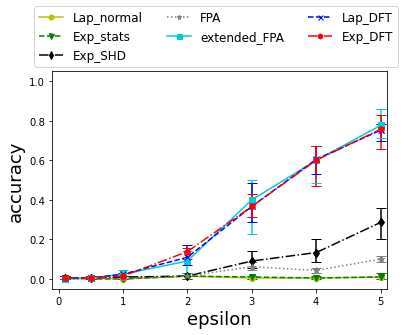

In [12]:
#K=10

N = 150
M = 5000

accuracy = np.zeros((7,7))
max_acc = np.zeros((7,7))
min_acc = np.ones((7,7))

sum_acc = np.zeros((7,7))

epsilon = [0.1, 0.5, 1, 2, 3, 4, 5]
y_err = np.zeros((2,7,7))

for j in range(3):
    accuracy = evaluation(10,150,5000)
    for i in range(7):
        for k in range(7):
            max_acc[i][k] = np.max([accuracy[i][k], max_acc[i][k]])
            min_acc[i][k] = np.min([accuracy[i][k], min_acc[i][k]])
            sum_acc[i][k] += accuracy[i][k]
    print(accuracy)

accuracy = sum_acc / 3
for k in range(7):
    y_err[0,:,k] = accuracy[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - accuracy[:,k]

print(accuracy)


fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(-0.1, 5.1)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='y', markeredgecolor = "y", color='y')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "y", linestyle = "-", label = "Lap_normal")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,1], marker="v", markersize=5, color = "green", linestyle = "--", label = "Exp_stats")
plt.errorbar(epsilon, accuracy[:,2], yerr = y_err[:,:,2], capsize=5, fmt='d', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, accuracy[:,2], marker="d", markersize=5, color = "black", linestyle = "dashdot", label = "Exp_SHD")
plt.errorbar(epsilon, accuracy[:,3], yerr = y_err[:,:,3], capsize=5, fmt='*', ecolor='gray', markeredgecolor = "gray", color='gray')
plt.plot(epsilon, accuracy[:,3], marker="*", markersize=5, color = "gray", linestyle = "dotted", label = "FPA")
plt.errorbar(epsilon, accuracy[:,4], yerr = y_err[:,:,4], capsize=5, fmt='s', ecolor='darkturquoise', markeredgecolor = "darkturquoise", color='darkturquoise')
plt.plot(epsilon, accuracy[:,4], marker="s", markersize=5, color = "darkturquoise", linestyle = "-", label = "extended_FPA")
plt.errorbar(epsilon, accuracy[:,5], yerr = y_err[:,:,5], capsize=5, fmt='x', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,5], marker="x", markersize=5, color = "blue", linestyle = "--", label = "Lap_DFT")
plt.errorbar(epsilon, accuracy[:,6], yerr = y_err[:,:,6], capsize=5, fmt='h', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, accuracy[:,6], marker="h", markersize=5, color = "red", linestyle = "dashdot", label = "Exp_DFT")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("accuracy_small_K=10.png")
fig.savefig("figs/accuracy_small_K=10.eps", bbox_inches="tight", pad_inches=0.05)